# I’m Something of a Painter Myself

## Importing Libraries

In [71]:
# Importing all the necessary libraries

# Installing modules that are not pre-installed
!pip install opendatasets --upgrade --quiet
!pip install albumentations --upgrade --quiet
!pip install torchinfo --upgrade --quiet

import os
from pathlib import Path
import shutil
from tqdm import tqdm
import opendatasets as od
import numpy as np
import cv2

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision.utils import make_grid, save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary

## Downloading Data

In [7]:
# Downloading the dataset
data_dir = Path('data_cyclegan')
if data_dir.exists():
    print('[INFO] Data directory exists, skipping the download.')
else:
    # Creating a data directory
    data_dir.mkdir(parents=True, exist_ok=True)
    od.download_kaggle_dataset(dataset_url='https://www.kaggle.com/datasets/suyashdamle/cyclegan',
                               data_dir=data_dir)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  johnp47


Your Kaggle Key:

  ································


100%|██████████| 3.40G/3.40G [00:38<00:00, 95.1MB/s]


In [11]:
# train directory
horse_train_dir = Path('data_cyclegan/cyclegan/horse2zebra/horse2zebra/trainA')
zebra_train_dir = Path('data_cyclegan/cyclegan/horse2zebra/horse2zebra/trainB')

# test directory
horse_test_dir = Path('data_cyclegan/cyclegan/horse2zebra/horse2zebra/testA')
zebra_test_dir = Path('data_cyclegan/cyclegan/horse2zebra/horse2zebra/testB')

len(horse_train_dir), len(horse_test_dir), len()

In [43]:
image_size = 256

# transform 
img_transform = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ToTensorV2()
], additional_targets={'image0': 'image'})

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset

In [42]:
class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform
        
        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.dataset_len = max(len(self.zebra_images), len(self.horse_images))
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)
        
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]
        
        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)
        
        zebra_img = np.array(Image.open(zebra_path).convert('RGB'))
        horse_img = np.array(Image.open(horse_path).convert('RGB'))
        
        if self.transform:
            aug = self.transform(image=zebra_img, image0=horse_img)
            zebra_img = aug['image']
            horse_img = aug['image0']
        
        return zebra_img, horse_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


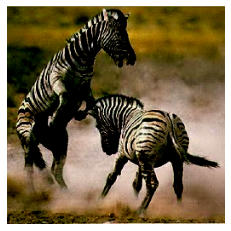

In [52]:
# dataset
train_dataset = HorseZebraDataset(zebra_train_dir, horse_train_dir, transform=img_transform)
plt.imshow(train_dataset[0][0].permute(1, 2, 0))
plt.axis(False);

## Discriminator Network

In [53]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size=4,
                      stride=stride,
                      padding=1,
                      bias=True,
                      padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

In [67]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,
                      features[0],
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      padding_mode='reflect'),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [68]:
# testing the discriminator network
x = torch.randn(128, 3, 256, 256, device=device)
discriminator_model = Discriminator(in_channels=3).to(device)
preds = discriminator_model(x)
preds.shape

torch.Size([128, 1, 30, 30])

In [76]:
summary(model=discriminator_model, input_size=(128, 3, 256, 256), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
Discriminator (Discriminator)            [128, 3, 256, 256]        [128, 1, 30, 30]          --                        True
├─Sequential (initial)                   [128, 3, 256, 256]        [128, 64, 128, 128]       --                        True
│    └─Conv2d (0)                        [128, 3, 256, 256]        [128, 64, 128, 128]       3,136                     True
│    └─LeakyReLU (1)                     [128, 64, 128, 128]       [128, 64, 128, 128]       --                        --
├─Sequential (model)                     [128, 64, 128, 128]       [128, 1, 30, 30]          --                        True
│    └─Block (0)                         [128, 64, 128, 128]       [128, 128, 64, 64]        --                        True
│    │    └─Sequential (conv)            [128, 64, 128, 128]       [128, 128, 64, 64]        131,200                   True
│    

## Generator Network